________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.868443
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.993919

time elapsed: 204.99s


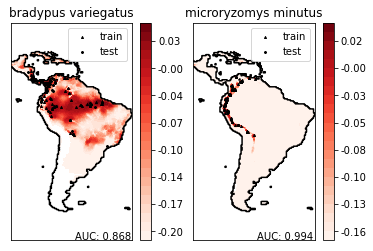

In [1]:
# Authors: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#          Jake Vanderplas <vanderplas@astro.washington.edu>
#
# License: BSD 3 clause

from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap

    basemap = True
except ImportError:
    basemap = False


def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=" ".join(species_name.split("_")[:2]))
    species_name = species_name.encode("ascii")
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts["species"] == species_name]
        bunch["pts_%s" % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts["dd long"])
        iy = np.searchsorted(ygrid, pts["dd lat"])
        bunch["cov_%s" % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(
    species=("bradypus_variegatus_0", "microryzomys_minutus_0")
):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print(
            "Note: when more than two species are provided,"
            " only the first two will be used"
        )

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(
        species[0], data.train, data.test, data.coverages, xgrid, ygrid
    )
    MM_bunch = create_species_bunch(
        species[1], data.train, data.test, data.coverages, xgrid, ygrid
    )

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[
        np.random.randint(low=0, high=data.Ny, size=10000),
        np.random.randint(low=0, high=data.Nx, size=10000),
    ].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    # Fit, predict, and plot for each species.
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ", end="")
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(
                projection="cyl",
                llcrnrlat=Y.min(),
                urcrnrlat=Y.max(),
                llcrnrlon=X.min(),
                urcrnrlon=X.max(),
                resolution="c",
            )
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(
                X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
            )
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format="%.2f")

        # scatter training/testing points
        plt.scatter(
            species.pts_train["dd long"],
            species.pts_train["dd lat"],
            s=2**2,
            c="black",
            marker="^",
            label="train",
        )
        plt.scatter(
            species.pts_test["dd long"],
            species.pts_test["dd lat"],
            s=2**2,
            c="black",
            marker="x",
            label="test",
        )
        plt.legend()
        plt.title(species.name)
        plt.axis("equal")

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean) / std)
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()

In [2]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn import svm, metrics

In [44]:
data.coverages.shape

(14, 1592, 1212)

In [45]:
data.keys()

dict_keys(['coverages', 'test', 'train', 'x_left_lower_corner', 'Nx', 'y_left_lower_corner', 'Ny', 'grid_size'])

In [42]:
data.Nx

1212

In [43]:
data.Ny

1592

In [3]:
# Load the compressed data
data = fetch_species_distributions()

In [3]:
# Set up the data grid
xgrid, ygrid = construct_grids(data)

In [4]:
data

{'coverages': array([[[ -128,  -128,  -128, ...,  -128,  -128,  -128],
         [ -128,  -128,  -128, ...,  -128,  -128,  -128],
         [ -128,  -128,  -128, ...,  -128,  -128,  -128],
         ...,
         [ -128,  -128,  -128, ...,  -128,  -128,  -128],
         [ -128,  -128,  -128, ...,  -128,  -128,  -128],
         [ -128,  -128,  -128, ...,  -128,  -128,  -128]],
 
        [[-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         ...,
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999]],
 
        [[ -128,  -128,  -128, ...,  -128,  -128,  -128],
         [ -128,  -128,  -128, ...,  -128,  -128,  -128],
         [ -128,  -128,  -128, ...,  -128,  -128,  -128],
         ...,
         [ -128,  -128,  -128, ...,  -128,  -128,  -128],
         [ 

In [5]:
xgrid

array([-94.75, -94.7 , -94.65, ..., -34.3 , -34.25, -34.2 ])

In [8]:
data.keys()    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

dict_keys(['coverages', 'test', 'train', 'x_left_lower_corner', 'Nx', 'y_left_lower_corner', 'Ny', 'grid_size'])

In [12]:
species=("bradypus_variegatus_0", "microryzomys_minutus_0")
bunch = create_species_bunch(
        species[0], data.train, data.test, data.coverages, xgrid, ygrid)

In [15]:
bunch.keys()

dict_keys(['name', 'pts_test', 'cov_test', 'pts_train', 'cov_train'])

In [16]:
bunch.pts_test

array([(b'bradypus_variegatus_0', -65.3833, -10.3833),
       (b'bradypus_variegatus_0', -63.6667, -17.45  ),
       (b'bradypus_variegatus_0', -64.4167, -16.    ),
       (b'bradypus_variegatus_0', -52.6667,  -3.8333),
       (b'bradypus_variegatus_0', -55.55  ,  -1.9167),
       (b'bradypus_variegatus_0', -55.2833,  -3.45  ),
       (b'bradypus_variegatus_0', -49.5   ,  -2.25  ),
       (b'bradypus_variegatus_0', -46.7333, -23.45  ),
       (b'bradypus_variegatus_0', -76.2667,   7.0167),
       (b'bradypus_variegatus_0', -76.7167,   8.1   ),
       (b'bradypus_variegatus_0', -75.05  ,   7.35  ),
       (b'bradypus_variegatus_0', -74.    ,  10.3   ),
       (b'bradypus_variegatus_0', -77.7667,   7.1167),
       (b'bradypus_variegatus_0', -76.6667,   5.7   ),
       (b'bradypus_variegatus_0', -75.6833,   8.2833),
       (b'bradypus_variegatus_0', -74.7333,   9.1167),
       (b'bradypus_variegatus_0', -74.3   ,   4.5833),
       (b'bradypus_variegatus_0', -73.6167,   4.15  ),
       (b'

In [17]:
bunch.cov_train

array([[ 75, 104,  10, ..., 266, 337, 279],
       [ 57, 116,  10, ..., 238, 317, 213],
       [ 57, 112,  10, ..., 230, 306, 203],
       ...,
       [ 66, 107,   2, ..., 250, 315, 245],
       [ 64,  98,   2, ..., 224, 283, 213],
       [ 62, 102,  10, ..., 279, 338, 279]], dtype=int16)

In [ ]:

def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=" ".join(species_name.split("_")[:2]))
    species_name = species_name.encode("ascii")
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts["species"] == species_name]
        bunch["pts_%s" % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts["dd long"])
        iy = np.searchsorted(ygrid, pts["dd lat"])
        bunch["cov_%s" % label] = coverages[:, -iy, ix].T

    return bunch

In [20]:
data.coverages

array([[[ -128,  -128,  -128, ...,  -128,  -128,  -128],
        [ -128,  -128,  -128, ...,  -128,  -128,  -128],
        [ -128,  -128,  -128, ...,  -128,  -128,  -128],
        ...,
        [ -128,  -128,  -128, ...,  -128,  -128,  -128],
        [ -128,  -128,  -128, ...,  -128,  -128,  -128],
        [ -128,  -128,  -128, ...,  -128,  -128,  -128]],

       [[-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        ...,
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999]],

       [[ -128,  -128,  -128, ...,  -128,  -128,  -128],
        [ -128,  -128,  -128, ...,  -128,  -128,  -128],
        [ -128,  -128,  -128, ...,  -128,  -128,  -128],
        ...,
        [ -128,  -128,  -128, ...,  -128,  -128,  -128],
        [ -128,  -128,  -128, ...,  -128,  -1

In [21]:
# coverages are the predictor data 
# train is the specices and location 

In [22]:
# Standardize features
mean = species.cov_train.mean(axis=0)
std = species.cov_train.std(axis=0)
train_cover_std = (species.cov_train - mean) / std

# Fit OneClassSVM
print(" - fit OneClassSVM ... ", end="")
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
clf.fit(train_cover_std)
print("done.")

AttributeError: 'tuple' object has no attribute 'cov_train'

In [27]:
# Standardize features
mean = bunch.cov_train.mean(axis=0)
std = bunch.cov_train.std(axis=0)
train_cover_std = (bunch.cov_train - mean) / std

# Fit OneClassSVM
print(" - fit OneClassSVM ... ", end="")
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
clf.fit(train_cover_std)
print("done.")

 - fit OneClassSVM ... done.


In [34]:
train_cover_std.shape

(81, 14)

In [38]:
bunch.cov_train.shape

(81, 14)

In [39]:
bunch

{'name': 'bradypus variegatus',
 'pts_test': array([(b'bradypus_variegatus_0', -65.3833, -10.3833),
        (b'bradypus_variegatus_0', -63.6667, -17.45  ),
        (b'bradypus_variegatus_0', -64.4167, -16.    ),
        (b'bradypus_variegatus_0', -52.6667,  -3.8333),
        (b'bradypus_variegatus_0', -55.55  ,  -1.9167),
        (b'bradypus_variegatus_0', -55.2833,  -3.45  ),
        (b'bradypus_variegatus_0', -49.5   ,  -2.25  ),
        (b'bradypus_variegatus_0', -46.7333, -23.45  ),
        (b'bradypus_variegatus_0', -76.2667,   7.0167),
        (b'bradypus_variegatus_0', -76.7167,   8.1   ),
        (b'bradypus_variegatus_0', -75.05  ,   7.35  ),
        (b'bradypus_variegatus_0', -74.    ,  10.3   ),
        (b'bradypus_variegatus_0', -77.7667,   7.1167),
        (b'bradypus_variegatus_0', -76.6667,   5.7   ),
        (b'bradypus_variegatus_0', -75.6833,   8.2833),
        (b'bradypus_variegatus_0', -74.7333,   9.1167),
        (b'bradypus_variegatus_0', -74.3   ,   4.5833),
    

In [ ]:
        pred = clf.decision_function((coverages_land - mean) / std)
        Z *= pred.min() # Z = Z*pred.min()
        Z[idx[0], idx[1]] = pred

In [46]:
    background_points = np.c_[
        np.random.randint(low=0, high=data.Ny, size=10000),
        np.random.randint(low=0, high=data.Nx, size=10000),
    ].T

In [49]:
background_points

array([[1265, 1015, 1135, ..., 1046,  659, 1241],
       [ 353,  978,  955, ...,  275, 1051,  160]])

In [54]:
pred_background = Z[background_points[0], background_points[1]]
pred_test = clf.decision_function((bunch.cov_test - mean) / std)
scores = np.r_[pred_test, pred_background]
y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
fpr, tpr, thresholds = metrics.roc_curve(y, scores)
roc_auc = metrics.auc(fpr, tpr)


In [53]:
land_reference = data.coverages[6]    

Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

# We'll predict only for the land points.
idx = np.where(land_reference > -9999)
coverages_land = data.coverages[:, idx[0], idx[1]].T

pred = clf.decision_function((coverages_land - mean) / std)
Z *= pred.min()
Z[idx[0], idx[1]] = pred

levels = np.linspace(Z.min(), Z.max(), 25)
Z[land_reference == -9999] = -9999

In [55]:
scores

array([-3.54923620e-05, -4.20096074e-02, -1.41276646e-01, ...,
       -9.99900000e+03, -2.11296263e-01, -9.99900000e+03])

In [ ]:
# background points (grid coordinates) for evaluation
np.random.seed(13)
background_points = np.c_[
    np.random.randint(low=0, high=data.Ny, size=10000),
    np.random.randint(low=0, high=data.Nx, size=10000),
].T

In [ ]:
# data.coverages is our weather data with spatial resolution 
# 14 categories at 1592x1212 positions 

In [10]:
np.random.randint(low=0, high=data.Ny, size=10000)

array([ 417,  965,   88, ..., 1211,  849,   60])

In [ ]:
# background is random values from 0 to 1592 or 0 to 1212


In [ ]:
# Standardize features
mean = species.cov_train.mean(axis=0)
std = species.cov_train.std(axis=0)
train_cover_std = (species.cov_train - mean) / std

# Fit OneClassSVM
print(" - fit OneClassSVM ... ", end="")
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
clf.fit(train_cover_std)

Standardize and train

In [ ]:
# Predict species distribution using the training data
Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

# We'll predict only for the land points.
### this is analagous to getting rid of the NaNs
idx = np.where(land_reference > -9999)
coverages_land = data.coverages[:, idx[0], idx[1]].T

pred = clf.decision_function((coverages_land - mean) / std)
Z *= pred.min()
Z[idx[0], idx[1]] = pred

#### 


In [ ]:
# Compute AUC with regards to background points
pred_background = Z[background_points[0], background_points[1]]
pred_test = clf.decision_function((species.cov_test - mean) / std)
scores = np.r_[pred_test, pred_background]
y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
fpr, tpr, thresholds = metrics.roc_curve(y, scores)
roc_auc = metrics.auc(fpr, tpr)
plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")

Compare with background points, i'm not actually sure what this is accomplishing